# Q1: Tri-VAE

In [4]:
import kagglehub
import shutil

## Dataset

### downloading datasets

In [5]:
try:
    path = kagglehub.dataset_download("haonanzhou1/ixit2-slices")
    shutil.copytree(path, './data/ixi')
except:
    print("folder already exists!")
shutil.rmtree(path)

100%|██████████| 781M/781M [00:11<00:00, 74.4MB/s]

Extracting files...


In [6]:
try:
    path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
except:
    print("folder already exists!")

100%|██████████| 4.16G/4.16G [00:41<00:00, 108MB/s]

Extracting files...


In [7]:
import os
shutil.copytree(os.path.join(path,"BraTS2020_TrainingData"), './data/brats_training/')
shutil.rmtree(path)

### showing a few instances

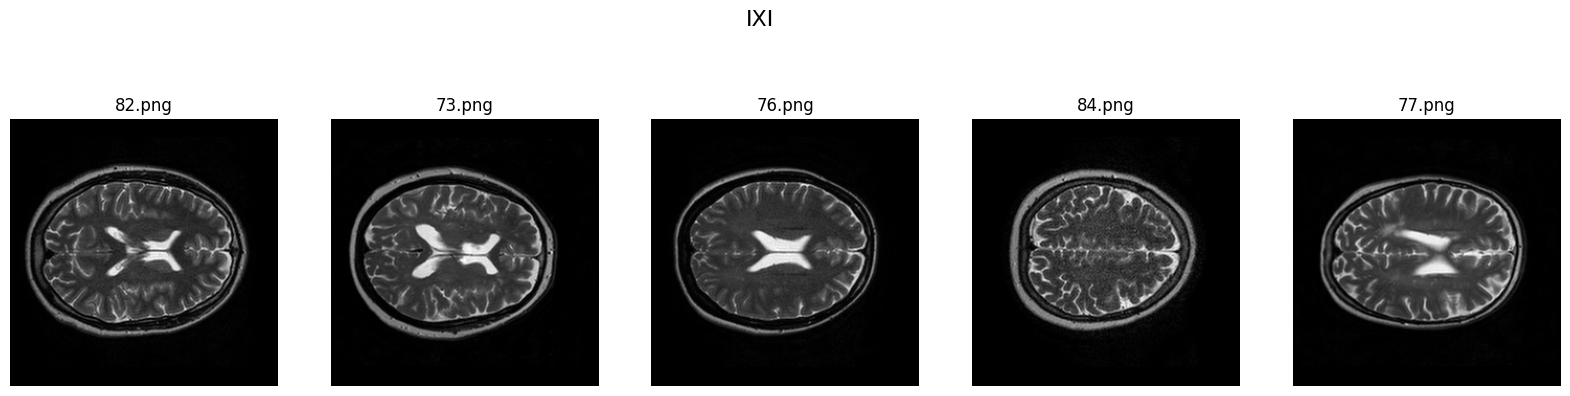

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

dataset_path = '/content/data/ixi/image slice-T2'

image_folders = random.sample(os.listdir(dataset_path), 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('IXI', fontsize=16)

for i, image_folder in enumerate(image_folders):
  image_name = random.sample(os.listdir(os.path.join(dataset_path, image_folder)), 1)[0]
  image_path = os.path.join(dataset_path, image_folder, image_name)
  image = Image.open(image_path)
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(image_name)
  axes[i].axis('off')

plt.show()

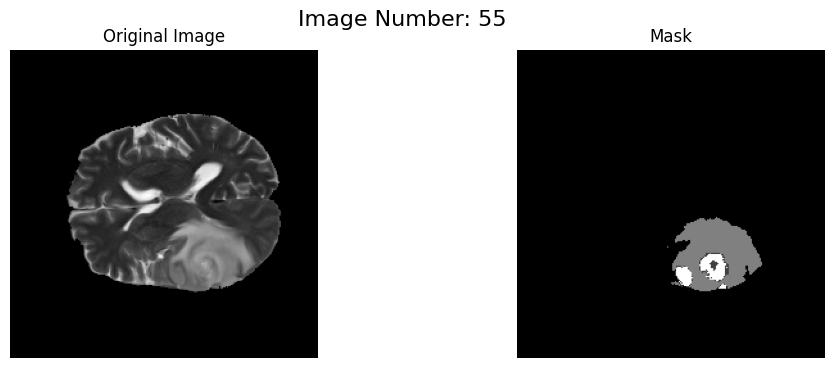

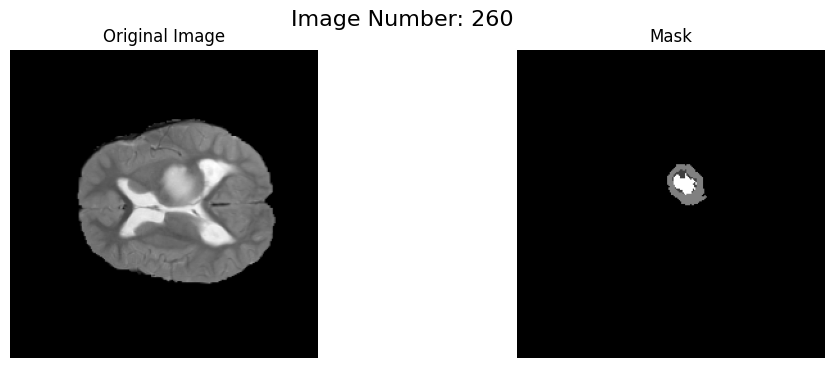

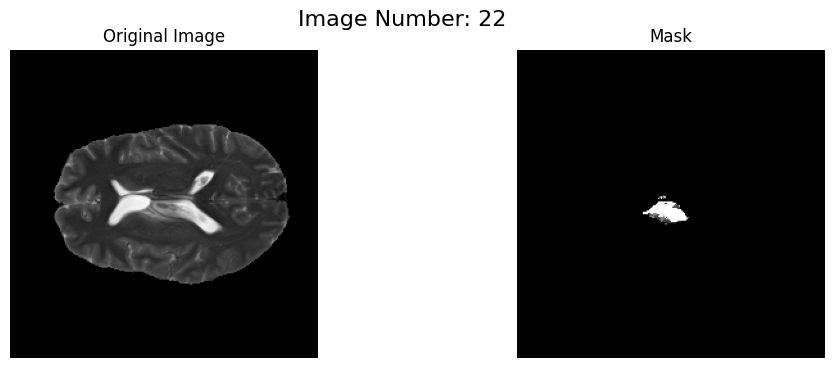

In [4]:
import matplotlib.pyplot as plt
import nibabel as nib
import random

def show_brats_data(image_addr, image_num):
  image = nib.load(image_addr)
  mask = nib.load(image_addr.replace('_t2', '_seg'))

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  fig.suptitle(f'Image Number: {image_num}', fontsize=16)

  axes[0].imshow(image.get_fdata()[:, :, image.shape[2] // 2], cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  axes[1].imshow(mask.get_fdata()[:, :, mask.shape[2] // 2], cmap='gray')
  axes[1].set_title('Mask')
  axes[1].axis('off')

  plt.show()

brats_folder='/content/data/brats_training/MICCAI_BraTS2020_TrainingData'
img_count=len([item for item in os.listdir(brats_folder) if os.path.isdir(os.path.join(brats_folder, item))])

for i in range(3):
  img_num=random.randint(0, img_count-1)
  img_addr=f'BraTS20_Training_{img_num:03}/BraTS20_Training_{img_num:03}_t2.nii'
  show_brats_data(os.path.join(brats_folder, img_addr), img_num)

### making datasets

In [55]:
from torch.utils.data import Dataset

class IXIDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img = self.df.iloc[idx]['image']

    if self.transform:
      img = self.transform(img)
    return img

class BratsDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img = self.df.iloc[idx]['image']
    mask = self.df.iloc[idx]['mask']

    if self.transform:
      mask = self.transform(mask)
      img = self.transform(img)
    return img, mask

In [15]:
import pandas as pd

dataset_path = '/content/data/ixi/image slice-T2'

image_folders = os.listdir(dataset_path)
image_data = []

for i, image_folder in enumerate(image_folders):
  image_names = os.listdir(os.path.join(dataset_path, image_folder))
  for image_name in image_names:
    image_path = os.path.join(dataset_path, image_folder, image_name)
    image = Image.open(image_path)

    image_data.append({'image_path': image_path, 'image': image})
ixi_df = pd.DataFrame(image_data)

In [16]:
len(ixi_df)

28850

In [59]:
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

brats_folder='/content/data/brats_training/MICCAI_BraTS2020_TrainingData'
brats_folders = [item for item in os.listdir(brats_folder) if os.path.isdir(os.path.join(brats_folder, item))]

brats_data = []

for i, brats_folder_name in enumerate(brats_folders):

  image_addr = os.path.join(brats_folder, brats_folder_name, f'{brats_folder_name}_t2.nii')
  mask_addr = image_addr.replace('_t2', '_seg')
  image = nib.load(image_addr)
  image = image.get_fdata()[:, :, image.shape[2] // 2]

  try:
    mask = nib.load(mask_addr)
  except:
    continue

  mask =  mask.get_fdata()[:, :, mask.shape[2] // 2]

  image = Image.fromarray(image)
  image = np.array(image.resize((256,256)))
  mask = Image.fromarray(mask)
  mask = np.array(mask.resize((256,256)))

  brats_data.append({'image_path': image_addr, 'mask_path': mask_addr, 'image': image, 'mask':mask})

brats_df = pd.DataFrame(brats_data)

In [13]:
len(brats_data)

368

In [60]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

ixi_dataset = IXIDataset(ixi_df, transform=transform)
brats_dataset = BratsDataset(brats_df, transform=transform)

In [46]:
small_ixi=IXIDataset(ixi_df[:100], transform=transform)

## VAE

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(256*256, 1024)
    self.fc21 = nn.Linear(1024, 20)  # Latent space
    self.fc22 = nn.Linear(1024, 20)
    self.fc3 = nn.Linear(20, 1024)
    self.fc4 = nn.Linear(1024, 256*256)

  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h3 = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))

  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, 256*256))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [25]:
device='cpu'

In [53]:
transform = transforms.ToTensor()
train_loader = DataLoader(small_ixi, batch_size=4, shuffle=True)

vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = F.binary_cross_entropy(recon_batch, data.view(-1, 256*256), reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss + kld
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch: {epoch} Loss: {train_loss / len(train_loader.dataset):.4f}')


In [54]:
for epoch in range(5):
    train(epoch)

Epoch: 0 Loss: 20377.4640
Epoch: 1 Loss: 16308.7482
Epoch: 2 Loss: 16054.4211
Epoch: 3 Loss: 15527.0305
Epoch: 4 Loss: 15239.1389


Avg Dice: 0.05740870087174699


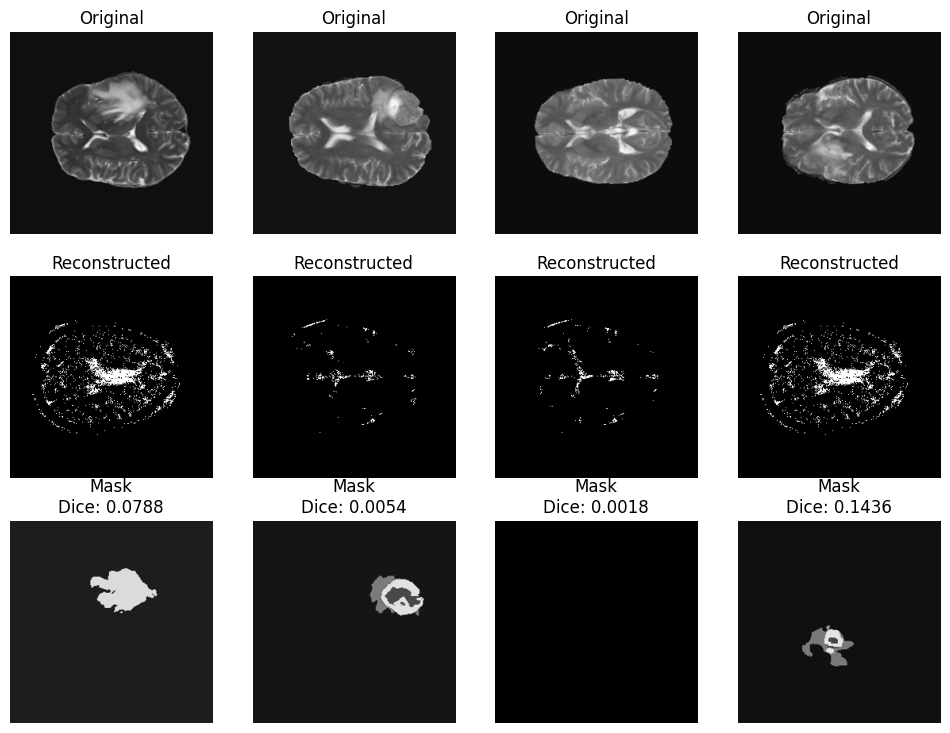

In [68]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

def dice_coefficient(pred, target):
    smooth = 1.0
    pred_flat = pred.view(-1).float()
    target_flat = target.view(-1).float()
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

vae.eval()
with torch.no_grad():
  for i, data in enumerate(test_loader):
    data, mask = data
    data = data.view(-1, 256*256)
    recon_batch, _, _ = vae(data)

    fig, axes = plt.subplots(3, data.size(0), figsize=(12, 9))
    dice_scores = []
    for j in range(data.size(0)):
      original_image = data[j].view(256, 256)
      reconstructed_image = recon_batch[j].view(256, 256)
      mask_image = mask[j].view(256, 256)
      dice_score = dice_coefficient(reconstructed_image, mask_image)
      dice_scores.append(dice_score.item())

      axes[0, j].imshow(original_image, cmap='gray')
      axes[0, j].set_title('Original')
      axes[0, j].axis('off')

      axes[1, j].imshow(reconstructed_image, cmap='gray')
      axes[1, j].set_title('Reconstructed')
      axes[1, j].axis('off')

      axes[2, j].imshow(mask_image, cmap='gray')
      axes[2, j].set_title(f'Mask\nDice: {dice_score:.4f}')
      axes[2, j].axis('off')

    print(f"Avg Dice: {sum(dice_scores)/len(data)}")

    plt.show()
    break
